# Multivariate Chebyshev Interpolation

Multivariate Chebyshev interpolation is a classical interpolation
method. It is applied for various applications in mathematical finance
as discussed e.g. in (Gass et al. 2016) and (Poetz 2020). An important
implementation of Chebyshev polynomials is the *chebfun* MATLAB project,
see (Driscoll, Hale, and Trefethen 2014).

In its classical tensor-based form multivariate Chebyshev interpolation
suffers from the *curse of dimensionality*. This means that the
computational effort grows exponentially with the number of input
dimensions of the target function. There are various approaches to
circumvent the exponential growth in computational effort. As an
example, we mention tensor trains which are recently proposed for
function approximation in (Antonov and Piterbarg 2021).

With this work we do not aim at lifting the curse of dimensionality.
Instead, we want to show how general-purpose high-level linear algebra
operations can be used to implement multivariate Chebyshev interpolation
efficiently given its intrinsic constraints. The high-level linear
algebra operations itself are typically implemented as efficiently as
possible by delegating calculations to BLAS routines (Blackford et al.
2002) and by applying parallelisation.

Chebyshev interpolation is specified on the $D$-dimensional cube
$\left[-1,1\right]^{D}$. We denote $p=\left(p_{1},\ldots,p_{D}\right)$
the elements of that standardised domain $\left[-1,1\right]^{D}$.
Original model inputs $x$ are assumed to be defined on a general
hyper-rectangular domain. Such general domain is transformed into the
standardised domain via an element-wise affine transformation.

We use the notation $p\left(x\right)$ and $x\left(p\right)$ to describe
the affine transformation from the general input domain to the
standardised domain and vice versa.

For a scalar parameter $p_{d}\in\left[-1,1\right]$ the Chebyshev
polynomial of degree $j$ is denoted $T_{j}\left(p_{d}\right)$. The
Chebyshev polynomial is defined via
$$T_{j}\left(p_{d}\right)=\cos\left(j\arccos\left(p_{d}\right)\right).\label{eq:Chebyshev-polynomial}$$
An equivalent representation is given via the recursion
$$\begin{aligned}T_{0}\left(p_{d}\right) & =1,\\
T_{1}\left(p_{d}\right) & =p_{d},\\
T_{j}\left(p_{d}\right) & =2p_{d}T_{j-1}\left(p_{d}\right)-T_{j-2}\left(p_{d}\right).
\end{aligned}$$

Multivariate Chebyshev polynomials are defined as products of
one-dimensional Chebyshev polynomials. Let
$\bar{j}=\left(j_{1},\ldots,j_{D}\right)$ be a multi-index and
$p\in\left[-1,1\right]^{D}$. The multivariate Chebyshev polynomial of
degree $\bar{j}$ is
$$T_{\bar{j}}\left(p\right)=\prod_{d=1}^{D}T_{j_{d}}\left(p_{d}\right).$$

Tensor based Chebyshev interpolation of a target function $y(x)$ for
(multi-index) degree $\bar{N}=\left(N_{1},\ldots,N_{D}\right)$ is given
by
$$f(x)=\sum_{0\leq\bar{j}\leq\bar{N}}c_{\bar{j}}T_{\bar{j}}\left(p\left(x\right)\right)=\sum_{j_{1}=0}^{N_{1}}\cdots\sum_{j_{D}=0}^{N_{D}}c_{\left(j_{1},\ldots,j_{D}\right)}\prod_{d=1}^{D}T_{j_{d}}\left(p_{d}\right).\label{eq:Chebyshev-interpolation}$$
Here, $p_{d}$ is the $d$<span lang="en-GB">-th</span> element of
$p\left(x\right)$.

In order to calculate the coefficients
$c_{\bar{j}}=c_{\left(j_{1},\ldots,j_{D}\right)}$ we introduce the
multivariate Chebyshev points (of second kind). We consider a
multi-index $\bar{k}$ and set
$$q_{\bar{k}}=\left(q_{k_{1}}^{1},\ldots,q_{k_{D}}^{D}\right)\in\left[-1,1\right]^{D}$$
with
$$q_{k_{d}}^{d}=\cos\left(\pi\frac{k_{d}}{N_{d}}\right),\;0\leq k_{d}\leq N_{d},\;d=1,\ldots,D.\label{eq:Chebyshev-points}$$
The mapping
$$x_{\bar{k}}=x\left(q_{\bar{k}}\right)=x\left(q_{k_{1}}^{1},\ldots,q_{k_{D}}^{D}\right)=\left[x\left(q_{k_{1}}^{1}\right),\ldots,x\left(q_{k_{D}}^{D}\right)\right]$$
defines the affine mapping from the standardised domain
$\left[-1,1\right]^{D}$ to the domain of the target function.

The coefficients $c_{\bar{j}}=c_{\left(j_{1},\ldots,j_{D}\right)}$ are
given as
$$c_{\bar{j}}=\left(\prod_{d=1}^{D}\frac{2^{\mathbbm{1}_{0<j_{d}<N_{d}}}}{N_{d}}\right)\sum_{k_{1}=0}^{N_{1}}\text{\textasciiacute\textasciiacute}\cdots\sum_{k_{D}=0}^{N_{D}}\text{\textasciiacute\textasciiacute}y\left(x\left(q_{k_{1}}^{1},\ldots,q_{k_{D}}^{D}\right)\right)\prod_{d=1}^{D}T_{j_{d}}\left(q_{k_{d}}^{d}\right).\label{eq:Chebyshev-coefficients}$$
Here, the notation $\sum\text{\textasciiacute\textasciiacute}$
represents the weighted sum where the first and last element are
assigned weight $\frac{1}{2}$ and all other elements are assigned unit
weight.

A first critical aspect of multivariate Chebyshev interpolation is that
the method initially requires $\prod_{d=1}^{D}\left(N_{d}+1\right)$
evaluations $y\left(x\left(q_{\bar{k}}\right)\right)$ of the target
function at the Chebyshev points $q_{\bar{k}}$. For larger dimensions
(e.g. $D>3$) and computationally expensive target functions this can be
a limitation.

Another critical aspect of multivariate Chebyshev interpolation concerns
the linear algebra operations. The evaluation of an interpolation $f(x)$
as well as the calibration of each coefficient $c_{\bar{j}}$ require a
calculation of the form
$$\sum_{j_{1}=0}^{N_{1}}\cdots\sum_{j_{D}=0}^{N_{D}}a_{\left(j_{1},\ldots,j_{D}\right)}\prod_{d=1}^{D}b_{j_{d}}.$$
A straight forward implementation of such a nested sum involves an
iterator along the Cartesian product of the indices
$$(0,\ldots,N_{1}),(0,\ldots,N_{2}),\ldots,(0,\ldots,N_{D}).$$ Within
each iteration we have $D$ multiplications. This amounts to
$D\,\prod_{d=1}^{D}\left(N_{d}+1\right)$ multiplications potentially
followed by an additions. This illustrates the exponential growth of
computational effort in terms of number of dimensions $D$.

In the following sections we will discuss how to implement above nested
sum efficiently by exploiting standardised high-level linear algebra
operations available in modern programming environments.

# High-level Linear Algebra Operations

In this section we discuss linear algebra operations that turn out to be
useful for the implementation of multivariate Chebyshev interpolation.
Such operations are often available in linear algebra modules of
high-level programming languages. Our example implementations are based
on Numpy, TensorFlow and Julia. But we aim at avoiding language or
module specific implementation choices.

#### Multi-dimensional arrays.

A guiding principle of our algorithm is the representation of data
structures as multi-dimensional arrays. Such multi-dimensional arrays
are also called tensors. Tensor operations are further discussed,
e.g. in (Golub and Loan 2013), Sec. 12.4.

A $D$-dimensional array ${\cal A}=\left(a_{\bar{j}}\right)$ is a
structure consisting of elements $a_{\bar{j}}\in\mathbb{R}$ where
$\bar{j}$ is a multi-index $\bar{j}=\left(j_{1},\ldots,j_{D}\right)$.
For each axis (or *mode*) $d=1,\ldots,D$ we have an index range
$j_{d}=1,\ldots,N_{d}$. The number of dimensions $D$ is also called the
order of the tensor.

Obviously, vectors and matrices represent the special cases of one- and
two-dimensional arrays or order-1 and order-2 tensors. Scalars can be
viewed as order-0 tensors.

The tuple $\left(N_{1},\ldots,N_{D}\right)$ represents the shape of the
tensor. The shape specifies the index ranges for each axis.

Elements of a tensor ${\cal A}$ are accessed via the function call
operator ${\cal A}\left(\cdot\right)$. That is
$${\cal A}\left(j_{1},\ldots,j_{D}\right)=a_{\left(j_{1},\ldots,j_{D}\right)}.$$
Sub-tensors or slices are specified by replacing specific indices
$j_{d}$ by “$:$” For example, ${\cal A}\left(:,j_{D-1},j_{D}\right)$ is
an order-$D-2$ tensor of shape $\left(N_{1},\ldots,N_{D-2}\right)$.

#### Cartesian product of vectors.

For a list of vectors $v^{1},\ldots,v^{D}$ with
$v^{d}=\left(v_{j_{d}}^{d}\right)_{j_{d}=1}^{N_{d}}$ ($d=1,\ldots,D$) we
define the Cartesian product
$$V=\text{product}\left(v^{1},\ldots,v^{D}\right)$$ as the
$\left(\prod_{d=1}^{D}N_{d}\right)\times D$-matrix $V$ with elements
$$V=\left[\begin{array}{ccccc}
v_{1}^{1} & v_{1}^{2} & \ldots & v_{1}^{D-1} & v_{1}^{D}\\
v_{1}^{1} & v_{1}^{2} & \ldots & v_{1}^{D-1} & v_{2}^{D}\\
 &  & \vdots\\
v_{N_{1}}^{1} & v_{N_{2}}^{2} & \ldots & v_{N_{D-1}}^{D-1} & v_{N_{D}-1}^{D}\\
v_{N_{1}}^{1} & v_{N_{2}}^{2} & \ldots & v_{N_{D-1}}^{D-1} & v_{N_{D}}^{D}
\end{array}\right].$$ In this ordering the elements in the last column
change fastest and the elements in the first column change slowest.

We will apply the Cartesian product operation for real vectors as well
as for index vectors. In particular, the Cartesian product of indices
$$J=\text{product}\left(\left(1,\ldots,N_{1}\right),\ldots,\left(1,\ldots,N_{D}\right)\right)$$
yields a vector of multi-indices $J=\left(\bar{j}\right)_{\bar{j}}$ that
allows to iterate the elements of a tensor
${\cal A}=\left(a_{\bar{j}}\right)$.

#### Re-shaping tensors.

Reshaping changes the order of a tensor but keeps the data elements
unchanged. The most basic form of re-shaping a tensor is the flattening
or vectorisation. We define
$$\text{vec}\left({\cal A}\right)=\left[\begin{array}{c}
a_{\left(1,1,\ldots,1,1\right)}\\
a_{\left(1,1,\ldots,1,2\right)}\\
\vdots\\
a_{\left(N_{1},N_{2},\ldots,N_{D-1},N_{D}-1\right)}\\
a_{\left(N_{1},N_{2},\ldots,N_{D-1},N_{D}\right)}
\end{array}\right]=\left[a_{\bar{j}}\right]_{\bar{j}\in J}.$$ That is,
we align the tensor elements with the last axis changing fastest and the
first axis changing slowest similarly as in the Cartesian product
specification.

A general re-shape operation
$${\cal B}=\text{reshape}\left({\cal A},\left(M_{1},\ldots,M_{E}\right)\right)$$
of a tensor ${\cal A}$ with shape $\left(N_{1},\ldots,N_{D}\right)$ into
a tensor ${\cal B}$ with shape $\left(M_{1},\ldots,M_{E}\right)$ and
$$\prod_{d=1}^{D}N_{d}=\prod_{e=1}^{E}M_{e}$$ is defined via
$$\text{vec}\left({\cal A}\right)=\text{vec}\left({\cal B}\right).$$

#### Element-wise tensor multiplication with broadcasting.

Element-wise tensor multiplication is used to delegate calculations to
efficient low-level implementations utilising e.g. BLAS routines and
parallelisation. This approach is particularly efficient when combined
with the concept of broadcasting.

Consider two tensors ${\cal A}=\left(a_{\bar{j}}\right)$ and
${\cal B}=\left(b_{\bar{j}}\right)$ with shape
$\left(N_{1},\ldots,N_{D}\right)$ and $\left(M_{1},\ldots,M_{D}\right)$.
We impose the constraint that
$$N_{d}=M_{d}\;\text{or}\;N_{d}=1\;\text{or}\;M_{d}=1\;\text{for}\;d=1,\ldots,D.$$
The element-wise product with broadcasting
$${\cal C}={\cal A}\;{.*}\;{\cal B}$$ yields a tensor ${\cal C}$ with
shape
$$\left(\max\left\{ N_{1},M_{1}\right\} ,\ldots,\max\left\{ N_{D},M_{D}\right\} \right).$$
The elements $c_{\bar{j}}=c_{\left(j_{1},\ldots,j_{D}\right)}$ of the
resulting tensor ${\cal C}$ are
$$c_{\left(j_{1},\ldots,j_{D}\right)}=a_{\left(\min\left\{ j_{1},N_{1}\right\} ,\ldots,\min\left\{ j_{D},N_{D}\right\} \right)}\cdot b_{\left(\min\left\{ j_{1},M_{1}\right\} ,\ldots,\min\left\{ j_{D},M_{D}\right\} \right)}.$$

Element-wise multiplication with broadcasting is the standard <span
lang="en-GB">behaviour</span> for multiplication of multi-dimensional
arrays in Numpy and TensorFlow. In Julia it is implemented by the .\*
operator.

#### Generalised matrix multiplication.

The Python Enhancement Proposal (PEP) 465 (Smith 2014) specifies a
matrix multiplication that generalises to multi-dimensional arrays. This
operation is implemented in Numpy and TensorFlow as the *matmul*
function.

Suppose, we have two tensors ${\cal A}$ and ${\cal B}$ with shape
$\left(N_{1},\ldots,N_{D}\right)$ and $\left(M_{1},\ldots,M_{D}\right)$.
We require that $D\geq2$,
$$N_{d}=M_{d}\;\text{or}\;N_{d}=1\;\text{or}\;M_{d}=1\;\text{for}\;d=1,\ldots,D-2,$$
and $$N_{D}=M_{D-1}.$$ The generalised matrix multiplication is defined
as $${\cal C}=\text{matmul}\left({\cal A},{\cal B}\right).$$ The result
tensor ${\cal C}$ is of shape
$$\left(\max\left\{ N_{1},M_{1}\right\} ,\ldots,\max\left\{ N_{D-2},M_{D-2}\right\} ,N_{D-1},M_{D}\right).$$
And the elements of ${\cal C}$ are calculated as
$${\cal C}\left(:,i,j\right)=\sum_{k=1}^{N_{D}}{\cal A}\left(:,i,k\right)\;{.*}\;{\cal B}\left(:,k,j\right)\label{eq:matmul}$$
for $i=1,\ldots,N_{d-1}$ and $j=1,\ldots,M_{d}$. Here,
${\cal C}\left(:,i,j\right)$ is the tensor of order $D-2$ where we fix
the last two axes of ${\cal C}$. Analogously,
${\cal A}\left(:,i,k\right)$ and ${\cal B}\left(:,k,j\right)$ are
specified.

We note that the generalised matrix multiplication can be related to the
*modal product* of tensors and matrices. Consider a matrix ${\cal M}$ of
shape $\left(M_{1},M_{2}\right)$ with $M_{2}=N_{d}$. The mode-$d$
product $${\cal C}={\cal A}\times_{d}{\cal M}$$ yields a tensor of shape
$$\left(N_{1},\ldots,N_{d-1},M_{1},N_{d+1},N_{D}\right).$$ The elements
of ${\cal C}=\left(c_{\left(j_{1},\ldots,j_{D}\right)}\right)$ are
calculated as
$${\cal C}{\left(j_{1},\ldots,j_{d-1},i,j_{d+1},j_{D}\right)}=\sum_{k=1}^{N_{d}}{\cal M}\left(i,k\right){\cal A}{\left(j_{1},\ldots,j_{d-1},k,j_{d+1},j_{D}\right)}$$
for $i=1,\ldots,M_{1}$.

It turns out that the mode-$D$ product along the last axis is
$${\cal A}\times_{D}{\cal M}=\text{matmul}\left({\cal A},\text{reshape}\left({\cal M}^{\top},\left(1,\ldots,1,M_{2},M_{1}\right)\right)\right).$$
We will use this observation to formulate Chebyshev interpolation as a
sequence of high-level $\text{matmul}\left(\cdot\right)$ operations
where we can rely on efficient low-level implementations.

# Reformulated Chebyshev Interpolation

We return to the task of calculating nested sums of the form
$$\sum_{j_{1}=0}^{N_{1}}\cdots\sum_{j_{D}=0}^{N_{D}}a_{\left(j_{1},\ldots,j_{D}\right)}\prod_{d=1}^{D}b_{j_{d}}.$$
The coefficients $a_{\left(j_{1},\ldots,j_{D}\right)}$ can be aligned in
an order-$D$ tensor ${\cal A}$. of shape
$\left(N_{1}+1,\ldots,N_{D}+1\right)$. Similarly, the Chebyshev
polynomial values $b_{j_{d}}$ can be arranged as $D$ matrices
${\cal B}^{d}$ of shape $\left(1,N_{d}+1\right)$.

With this notation the nested sum becomes a sequence of modal products
$$\sum_{j_{1}=0}^{N_{1}}\cdots\sum_{j_{D}=0}^{N_{D}}a_{\left(j_{1},\ldots,j_{D}\right)}\prod_{d=1}^{D}b_{j_{d}}={\cal C}\left(1,\ldots,1\right)$$
where the order $D$ tensor ${\cal C}$ with shape
$\left(1,\ldots,1\right)$ is
$${\cal C}=\left(\left({\cal A}\times_{D}{\cal B}^{D}\right)\times_{D-1}\ldots\right)\times_{1}{\cal B}^{1}.$$

The property that the multivariate Chebyshev interpolation formula can
be written as modal product is also observed in (Poetz 2020, sec. 5.1).
We also note that the sequence of modal products is invariant with
respect to its ordering. See (Golub and Loan 2013Theorem 12.4.1). Thus,
we could also calculate
$${\cal C}=\left(\left({\cal A}\times_{1}{\cal B}^{1}\right)\times_{2}\ldots\right)\times_{D}{\cal B}^{D}.$$

#### Chebyshev batch calculation.

The interpolation function $f$ from equation
(<a href="#eq:Chebyshev-interpolation" data-reference-type="ref" data-reference="eq:Chebyshev-interpolation">[eq:Chebyshev-interpolation]</a>)
often needs to be evaluated for various inputs $x^{1},\ldots,x^{N}$. In
such a context we call $N$ (without subscript) the batch size for
evaluation. In order to utilize BLAS routines and parallelisation we
want to avoid manual iteration over the elements of a batch. Instead, we
carefully use broadcasting to vectorise calculations.

Input to the Chebyshev batch calculation are a matrix ${\cal P}$ and an
order-$D$ tensor ${\cal C}$. The matrix ${\cal P}$ is of shape
$\left(D,N\right)$ and consists of points from the standardised domain
$\left[-1,1\right]^{D}$. That is,
$${\cal P}=\left[p\left(x^{1}\right),\ldots,p\left(x^{N}\right)\right].$$
The tensor ${\cal C}$ is of shape $\left(N_{1}+1,\ldots,N_{D}+1\right)$
and for the usage of interpolation consists of the Chebyshev
coefficients $c_{\bar{j}}$ from equation
(<a href="#eq:Chebyshev-coefficients" data-reference-type="ref" data-reference="eq:Chebyshev-coefficients">[eq:Chebyshev-coefficients]</a>).

For each axis $d$ and input row ${\cal P}\left(d,:\right)$ we calculate
a matrix of Chebyshev polynomial values ${\cal T}^{d}$ of shape
$\left(N_{d}+1,N\right)$ with entries
$$\begin{aligned}{\cal T}^{d}\left(1,:\right) & =\left(1,\ldots,1\right),\\
{\cal T}^{d}\left(2,:\right) & ={\cal P}\left(d,:\right),\\
{\cal T}^{d}\left(j,:\right) & =2\,{\cal P}\left(d,:\right)\;{.*}\;{\cal T}^{d}\left(j-1,:\right)-{\cal T}^{d}\left(j-2,:\right),
\end{aligned}
\label{eq:multi-Chebyshev-polynomial}$$ for $j=3,\ldots,N_{d}+1$.

With algorithm
<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>
we calculate a vector
$${\cal R}=\left[f\left(x^{1}\right),\ldots,f\left(x^{N}\right)\right]^{\top}.$$

Initialise
${\cal R}\leftarrow\text{reshape}\left({\cal C},\left(1,N_{1}+1,\ldots,N_{D}+1\right)\right)$
by adding a trivial first axis. Remove remaining trivial axis
${\cal R}\leftarrow\text{reshape}\left({\cal R},\left(N\right)\right)$.

We assess the computational effort of the Chebyshev batch calculation in
algorithm
<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>.
Re-shape and matrix transposition operations are cheap because they do
not require data access or data manipulation. We count multiplications
which may be followed by an addition as a single operation.

Chebyshev matrix calculation in step 3 amounts to
$$2N\sum_{d=1}^{D}\left(N_{d}-1\right)$$ operations. This is more or
less ${\cal O}\left(N\right)$ and relatively cheap.

The computationally expensive step is the generalised matrix
multiplication in step 9. Here we count
$$N\sum_{d-1}^{D}\underbrace{\left(\prod_{j=1}^{d-1}\left(N_{j}+1\right)\right)}_{{\text{broadcasting}}}\underbrace{\left(N_{d}+1\right)}_{\text{multiplications\;.*}}=N\sum_{d-1}^{D}\,\prod_{j=1}^{d}\left(N_{j}+1\right)$$
operations. For $\hat{N}=\max\left\{ N_{1},\ldots,N_{D}\right\} \geq1$
we get the estimate
$$N\sum_{d-1}^{D}\,\prod_{j=1}^{d}\left(N_{j}+1\right)\leq N\sum_{d-1}^{D}\left(\hat{N}+1\right)^{d}<2N\left(\hat{N}+1\right)^{D}.$$
The proposed algorithm still suffers from the exponential growth in the
number of dimensions $D$. However, we save a factor of $D/2$ compared to
a standard implementation via Cartesian product.

#### Chebyshev coefficient calibration.

Now, we analyse the calculation of the Chebyshev coefficients
$c_{\bar{j}}$ from equation
(<a href="#eq:Chebyshev-coefficients" data-reference-type="ref" data-reference="eq:Chebyshev-coefficients">[eq:Chebyshev-coefficients]</a>),
$$c_{\bar{j}}=\underbrace{\left(\prod_{d=1}^{D}\frac{2^{\mathbbm{1}_{0<j_{d}<N_{d}}}}{N_{d}}\right)}_{v_{\bar{j}}}\sum_{k_{1}=0}^{N_{1}}\text{\textasciiacute\textasciiacute}\cdots\sum_{k_{D}=0}^{N_{D}}\text{\textasciiacute\textasciiacute}y\left(x\left(q_{k_{1}}^{1},\ldots,q_{k_{D}}^{D}\right)\right)\prod_{d=1}^{D}T_{j_{d}}\left(q_{k_{d}}^{d}\right)$$
for
$$\bar{j}\in J=\text{product}\left(\left(0,\ldots,N_{1}\right),\ldots,\left(0,\ldots,N_{D}\right)\right).$$
We will demonstrate how this calculation can be related to the Chebyshev
batch calculation from algorithm
<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>.

Starting point for the calculation are multivariate Chebyshev points
$q_{\bar{k}}=\left(q_{k_{1}}^{1},\ldots,q_{k_{D}}^{D}\right)\in\left[-1,1\right]^{D}$
from equation
(<a href="#eq:Chebyshev-points" data-reference-type="ref" data-reference="eq:Chebyshev-points">[eq:Chebyshev-points]</a>)
for $\bar{k}\in J$. The multivariate Chebyshev points are collected as
Cartesian product in the matrix ${\cal Q}$of shape
$\left(\prod_{d=1}^{D}\left(N_{d}+1\right),D\right)$ such that
$$Q=\left[q_{\bar{k}}\right]_{\bar{k}\in J}.$$ For each row
$q_{\bar{k}}$ in $Q$ we calculate the target function value vector
$\left[y_{\bar{k}}\right]_{\bar{k}\in J}$ such that
$$\left[y_{\bar{k}}\right]_{\bar{k}\in J}=\left[y\left(x\left(q_{\bar{k}}\right)\right)\right]_{\bar{k}\in J}.\label{eq:function-values}$$
The weighs of the $\sum\text{\textasciiacute\textasciiacute}$ operator
are
$$\left[w_{\bar{k}}\right]_{\bar{k}\in J}=\left[2^{-\left(N_{d}-\sum_{d=1}^{D}\mathbbm{1}_{0<k_{d}<N_{d}}\right)}\right]_{\bar{k}\in J}.\label{eq:function-weights}$$
Similarly, we calculate the vector of coefficient weights
$$\left[v_{\bar{j}}\right]_{\bar{j}\in J}=\left[\prod_{d=1}^{D}\frac{2^{\mathbbm{1}_{0<j_{d}<N_{d}}}}{N_{d}}\right]_{\bar{j}\in J}.\label{eq:coefficient-weights}$$
We note that calculation of the weight vectors
$\left[w_{\bar{k}}\right]_{\bar{k}\in J}$ and
$\left[v_{\bar{j}}\right]_{\bar{j}\in J}$ typically can also be
vectorisied and do not require manual iteration over the index $\bar{k}$
or $\bar{j}$.

With the weights $\left[w_{\bar{k}}\right]_{\bar{k}\in J}$ and function
values $\left[y_{\bar{k}}\right]_{\bar{k}\in J}$ we can re-write the
coefficient calculation using standard sum operator and
$$\frac{c_{\bar{j}}}{v_{\bar{j}}}=\sum_{k_{1}=0}^{N_{1}}\cdots\sum_{k_{D}=0}^{N_{D}}w_{\bar{k}}y_{\bar{k}}\prod_{d=1}^{D}T_{j_{d}}\left(q_{k_{d}}^{d}\right).$$
From equations
(<a href="#eq:Chebyshev-polynomial" data-reference-type="ref" data-reference="eq:Chebyshev-polynomial">[eq:Chebyshev-polynomial]</a>)
and
(<a href="#eq:multi-Chebyshev-polynomial" data-reference-type="ref" data-reference="eq:multi-Chebyshev-polynomial">[eq:multi-Chebyshev-polynomial]</a>)
we observe that $$\begin{aligned}
T_{j_{d}}\left(q_{k_{d}}^{d}\right) & =\cos\left(j_{d}\arccos\left(\cos\left(\pi\frac{k_{d}}{N_{d}}\right)\right)\right)\\
 & =\cos\left(k_{d}\arccos\left(\cos\left(\pi\frac{j_{d}}{N_{d}}\right)\right)\right)\\
 & =T_{k_{d}}\left(q_{j_{d}}^{d}\right).\end{aligned}$$ This yields the
desired form
$$\frac{c_{\bar{j}}}{v_{\bar{j}}}=\sum_{k_{1}=0}^{N_{1}}\cdots\sum_{k_{D}=0}^{N_{D}}w_{\bar{k}}y_{\bar{k}}\prod_{d=1}^{D}T_{k_{d}}\left(q_{j_{d}}^{d}\right).\label{eq:Chebyshev-calibration}$$
The right-hand side of equation
(<a href="#eq:Chebyshev-calibration" data-reference-type="ref" data-reference="eq:Chebyshev-calibration">[eq:Chebyshev-calibration]</a>)
is of the same form as the Chebyshev interpolation formula in equation
(<a href="#eq:Chebyshev-interpolation" data-reference-type="ref" data-reference="eq:Chebyshev-interpolation">[eq:Chebyshev-interpolation]</a>).
We only need to identify the coefficients $c_{\bar{k}}$ with the
weighted function values $w_{\bar{k}}y_{\bar{k}}$ and evaluate the
interpolation at the Chebyshev points $q_{\bar{j}}$. Thus, we can re-use
algorithm
<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>
for efficient implementation.

We summarise the Chebyshev coefficient calibration in algorithm
<a href="#alg:Chebyshev-coefficient-calibration" data-reference-type="ref" data-reference="alg:Chebyshev-coefficient-calibration">[alg:Chebyshev-coefficient-calibration]</a>.

Calculate
$J=\text{product}\left(\left(0,\ldots,N_{1}\right),\ldots,\left(0,\ldots,N_{D}\right)\right)$.
Calculate cartesian product of Chebyshev points
$Q=\left[q_{\bar{k}}\right]_{\bar{k}\in J}$ from
(<a href="#eq:Chebyshev-points" data-reference-type="ref" data-reference="eq:Chebyshev-points">[eq:Chebyshev-points]</a>).
Calculate function values $\left[y_{\bar{k}}\right]_{\bar{k}\in J}$ from
(<a href="#eq:function-values" data-reference-type="ref" data-reference="eq:function-values">[eq:function-values]</a>)
Calculate function weights $\left[w_{\bar{k}}\right]_{\bar{k}\in J}$
from
(<a href="#eq:function-weights" data-reference-type="ref" data-reference="eq:function-weights">[eq:function-weights]</a>)
Form coefficient tensor ${\cal Y} = \text{reshape}\left(
    \left[w_{\bar{k}}\right]_{\bar{k}\in J}\;.*\;\left[y_{\bar{k}}\right]_{\bar{k}\in J},
    \left(N_1+1,\ldots,N_D+1\right)
  \right)$ Call algorithm
<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>
with inputs ${\cal Y}$ and $Q^\top$. This yields a vector
$\left[r_{\bar{j}}\right]_{\bar{j}\in J}$. Calculate coefficient weights
$\left[v_{\bar{j}}\right]_{\bar{j}\in J}$ from
(<a href="#eq:coefficient-weights" data-reference-type="ref" data-reference="eq:coefficient-weights">[eq:coefficient-weights]</a>).
Calculate Chebyshev coefficient tensor ${\cal C} = \text{reshape}\left(
    \left[v_{\bar{j}}\right]_{\bar{j}\in J}\;.*\;\left[r_{\bar{j}}\right]_{\bar{j}\in J},
    \left(N_1+1,\ldots,N_D+1\right)
  \right)$

The key drivers of computational effort for algorithm
<a href="#alg:Chebyshev-coefficient-calibration" data-reference-type="ref" data-reference="alg:Chebyshev-coefficient-calibration">[alg:Chebyshev-coefficient-calibration]</a>
lie in the function evaluation in step 3 and in the call of algorithm
<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>
in step 6. Step 3 requires $\prod_{d=1}^{D}\left(N_{d}+1\right)$
evaluations of the target function. In step 6 we call algorithm
<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>
with batch size $N=\prod_{d=1}^{D}\left(N_{d}+1\right)$. Consequently,
we end up with
$$\prod_{d=1}^{D}\left(N_{d}+1\right)\,\sum_{d-1}^{D}\,\prod_{j=1}^{d}\left(N_{j}+1\right)\sim\prod_{d=1}^{D}\left(N_{d}+1\right)^{2}$$
operations. This definitely remains the bottleneck of the method for
larger dimensions.

Besides the intrinsic computational effort,
algorithm<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>
and algorithm
<a href="#alg:Chebyshev-coefficient-calibration" data-reference-type="ref" data-reference="alg:Chebyshev-coefficient-calibration">[alg:Chebyshev-coefficient-calibration]</a>
demonstrate how calculations can be delegated to a few calls of
generalised matrix multiplications. This allows exploiting efficient
BLAS implementations and parallelisation.

#### Implementation.

Implementations of
algorithm<a href="#alg:Chebyshev-batch-calculation" data-reference-type="ref" data-reference="alg:Chebyshev-batch-calculation">[alg:Chebyshev-batch-calculation]</a>
and algorithm
<a href="#alg:Chebyshev-coefficient-calibration" data-reference-type="ref" data-reference="alg:Chebyshev-coefficient-calibration">[alg:Chebyshev-coefficient-calibration]</a>
are provided at
[github.com/sschlenkrich/MultivariateChebyshev](github.com/sschlenkrich/MultivariateChebyshev).
We choose Numpy and TensorFlow as packages for high-level linear algebra
operations. Both packages are available in the Python programming
language. Moreover, we implement the algorithms in the Julia programming
language. Julia is designed as high-level high-performance language. If
needed, Julia can also be accessed from Python. A comparison of the
implementations in `src/multivariate_chebyshev_numpy.py`,
`src/multivariate_chebyshev_tensorflow.py` and
`src/multivariate_chebyshev_julia.jl` demonstrates that the proposed
algorithms are rather generic.

We use above implementations to demonstrate the usage of multivariate
Chebyshev implementation and to assess which module might be best suited
from a performance perspective.

# Case Study - Implied Volatility Surface of Heston Model

In this section we describe numerical results when applying our
Chebyshev implementations to interpolate implied volatilities in a
Heston model. The example is chosen because on the one hand side Heston
model is a relevant model in practice to price FX and equity options. On
the other hand side pricing Vanilla options and calculating implied
volatility in Heston model is computationally feasible such that the
resulting target function can easily be used to calibrate relatively
large Chebyshev tensors.

Implied volatility calculation with Chebyshev polynomials is also
analysed in (Glau, Madan, and Poetz 2019). This paper focuses on
inverting the Black formula via bivariate interpolation. Another related
work is (Zeron and Ruiz 2020). In that paper the authors demonstrate
that Chebyshev tensors can also be applied to approximate implied
volatility in the more Rough Bergomi model.

Our focus in this section is comparing the computational effort of our
implementations using Numpy, TensorFlow and Julia. In order to put the
results into the context of the model we give a high-level overview of
our Heston model example.

#### Heston model specification.

Heston model is a model for the price process of a financial asset
$S_{t}$. The price process $S_{t}$ is described by the diffusion
$$\begin{aligned}dS_{t} & =\mu S_{t}dt+\sqrt{v_{t}}S_{t}dW_{t}^{S},\\
dv_{t} & =\kappa\left(\theta-v_{t}\right)dt+\xi\sqrt{v_{t}}dW_{t}^{v},\\
dW_{t}^{S}dW_{t}^{v} & =\rho dt,
\end{aligned}$$ with initial conditions $S_{0}>0$ and $v_{0}>0$ at $t=0$
and correlated Brownian motions $W_{t}^{S}$ and $W_{t}^{v}$.

For option pricing methods in Heston model we refer to the standard
literature, see e.g. XYZ. Implied volatilities for a given term (or time
to maturity) $T$ and strike price $K$ are obtained by inverting Black’s
formula given a forward Vanilla option price derived in Heston model.

For implied volatility modelling we are interested in forward prices. As
a consequence, we can disregard the drift $\mu$. Implied volatility in
Heston model is driven by the parameters of the squared volatility
process $v_{t}$. In particular, we have the following properties.

-   $\sqrt{v_{0}}$ controls short term volatility.

-   $\sqrt{\theta}$ controls long term volatility.

-   $\log(2)/\kappa$ represents the half life of the expectation of
    $v_{t}$ moving from $v_{0}$ to $\theta$. This controls the term
    structure of at-the-money volatilities.

-   $\rho$ controls the volatility skew (or volatility slope in strike
    direction).

-   $\xi$ controls the volatility smile (or volatility curvature in
    strike direction).

For our parametrisation of implied volatilities we will use two
properties of Heston model.

#### Expectation of squared volatility.

The expectation of the squared volatility $v_{T}$ for a given term
$T\geq0$ is given as
$$\mathbb{E}\left[v_{T}\right]=v_{0}e^{-\kappa T}+\theta\left(1-e^{-\kappa T}\right).$$
We use this this property to define an *average standard deviation* of
asset prices as
$$\nu_{(v_{0},\theta,\kappa)}(T)=\sqrt{\left[v_{0}e^{-\kappa T}+\theta\left(1-e^{-\kappa T}\right)\right]T}.$$
The average standard deviation is used to normalise option strikes $K$.
That is, We define the option moneyness as
$${\cal M}=\frac{\log\left(K/S_{0}\right)}{\nu_{(v_{0},\theta,\kappa)}(T)}.$$

#### Feller condition.

The Feller condition for the squared volatility process is
$$\xi^{2}\leq2\kappa\theta.$$ This condition ensures that the squared
volatility process remains positive, i.e. $v_{t}>0$ for $t>0$. Violation
of Feller condition e.g. by high vol-of-vol parameter $\xi$ is typically
accepted to achieve reasonable fits in calibrations. However, high
vol-of-vol parameters may cause numerical instabilities.

In order to control (or limit) the extend of Feller condition violation
we use a *Feller factor* parameter to parametrise volatility smile. We
define the Feller factor as $${\cal F}=\frac{\xi^{2}}{2\kappa\theta}.$$

#### Implied volatility function parametrisation.

For a given model or market observation implied volatility $\sigma_{IV}$
is a function of the option term $T$ and the strike price $K$. That is
$$\sigma_{IV}\left(T,K\right)$$ also forms a volatility surface.

For this analysis we extend the volatility surface function by the
Heston model parameters and apply a parameter transformation. Our target
function is $f:{\cal D}\rightarrow R$ with
${\cal D}\subset\mathbb{R}^{8}$ such that
$$f\left(x\right)=\sigma_{IV}\left(T,K;S_{0},v_{0},\theta,\kappa,\rho,\xi\right).$$
The target function argument $x$ is specified as
$$x=\left[\begin{array}{c}
x_{0}\\
x_{1}\\
x_{2}\\
x_{3}\\
x_{4}\\
x_{5}\\
x_{6}\\
x_{7}
\end{array}\right]=\left[\begin{array}{c}
T\\
{\cal M}\\
S_{0}\\
\sqrt{v_{0}}\\
\sqrt{\theta/v_{0}}\\
0.7/\kappa\\
\rho\\
{\cal F}
\end{array}\right].$$ The input domain ${\cal D}$ is the hyper-rectangle
with boundaries as specified in Table
<a href="#tab:Boundaries-of-function-domain" data-reference-type="ref" data-reference="tab:Boundaries-of-function-domain">1</a>.

|                 Parameter                  | Lower boundary | Upper boundary |
|:------------------------------------------:|:--------------:|:--------------:|
|              option term $T$               |     $1/12$     |     $5.00$     |
|            moneyness ${\cal M}$            |    $-3.00$     |     $3.00$     |
|        initial asset price $S_{0}$         |     $0.50$     |     $1.50$     |
|     initial volatility $\sqrt{v_{0}}$      |     $0.10$     |     $0.50$     |
| long volatility ratio$\sqrt{\theta/v_{0}}$ |     $0.50$     |     $2.00$     |
|        decay half life $0.7/\kappa$        |     $1.00$     |     $5.00$     |
|             correlation $\rho$             |    $-0.80$     |     $0.80$     |
|          Feller factor ${\cal F}$          |     $0.01$     |     $4.00$     |

<span id="tab:Boundaries-of-function-domain"
label="tab:Boundaries-of-function-domain">\[tab:Boundaries-of-function-domain\]</span>Boundaries
of function domain ${\cal D}$.

Some representative volatility smiles of the target function and
Chebyshev interpolation using degrees $N_{d}=2$ for all $d=1,\ldots,8$
are illustrated in Figure
<a href="#fig:Example-implied-volatility" data-reference-type="ref" data-reference="fig:Example-implied-volatility">1</a>.
In this graph lines represent target function and dots represent
Chebyshev interpolation. Note that $N_{d}$=2 corresponds to quadratic
interpolation in strike direction. We find that quadratic interpolation
allows to capture the general shape of the volatility surface. However,
there are still considerable differences between Heston model target
function and Chebyshev interpolation function.

<figure>
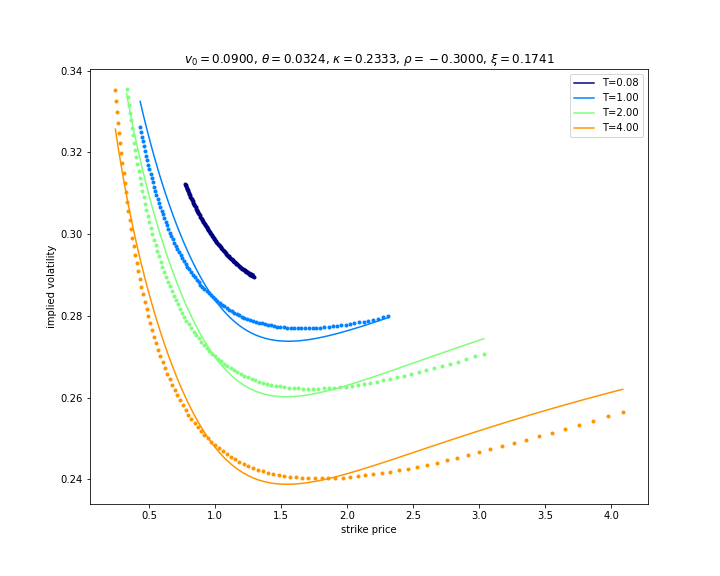<figcaption aria-hidden="true">Figure 1: <span id="fig:Example-implied-volatility" label="fig:Example-implied-volatility">[fig:Example-implied-volatility]</span>Example implied volatility smiles of Heston model and Chebyshev interpolation with degrees <span class="math inline">\(N_{d}=2\)</span> for all dimensions. Lines represent target function and dots represent Chebyshev interpolation.</figcaption>
</figure>

#### Performance Analysis.

We analyse the computational performance of the methods. For this
exercise we use the eight-dimensional target function $f$ for modelling
Heston implied volatilities.We use an equal number of degrees $N=N_{d}$
across all dimensions $d=1,\ldots,8$ and let $N$ run from $1$ to $3$. As
benchmark we consider the Chebyshev coefficient calculation. This
routine is implemented in the function *chebyshev_coefficients* in our
example implementations. The computational effort of this routine is
proportional to the square of number of Chebyshev points.

Computational performance is measured as run time on an Intel Core
i7-8650U CPU with 1.90GHz, 4 cores and 16 GB RAM. Programming
environment is Python 3.7 with Numpy 1.21.5, TensorFlow 2.7.0 and Julia
1.7.2. For each $N_{d}$ we run calculations five times, exclude minimum
and maximum and average the remaining three run times. The results of
our numerical experiment are summarised in Table
<a href="#tab:Run-time-of-Chebyshev-tensor-calibation" data-reference-type="ref" data-reference="tab:Run-time-of-Chebyshev-tensor-calibation">2</a>.

| Degrees $N_{d}$ | \# Chebyshev points | Target function evaluation |  Numpy   | TensorFlow |  Julia   |
|:---------------:|:-------------------:|:--------------------------:|:--------:|:----------:|:--------:|
|       $1$       |     $2^{8}=256$     |          $0.0478$          | $0.0020$ |  $0.0130$  | $0.0064$ |
|       $2$       |    $3^{8}=6,561$    |           $1.07$           |  $0.32$  |   $0.19$   |  $0.58$  |
|       $3$       |   $4^{8}=65,536$    |          $11.35$           | $23.94$  |  $12.50$   | $70.54$  |

<span id="tab:Run-time-of-Chebyshev-tensor-calibation"
label="tab:Run-time-of-Chebyshev-tensor-calibation">\[tab:Run-time-of-Chebyshev-tensor-calibation\]</span>Run
time in seconds of Chebyshev tensor calibration.

We find from the results in Table
<a href="#tab:Run-time-of-Chebyshev-tensor-calibation" data-reference-type="ref" data-reference="tab:Run-time-of-Chebyshev-tensor-calibation">2</a>.
that the computational effort for Chebyshev coefficient calculation is
proportional to the square of the number of Chebyshev points. The number
of Chebyshev points itself for this example is proportional to the
polynomial degree to the power of eight. This behaviour is expected and
illustrates the impact of the curse of dimensionality for classical
multivariate Chebyshev interpolation.

When comparing Numpy with TensorFlow we see that for small number of
Chebyshev points Numpy outperforms TensorFlow whereas for larger number
of Chebyshev points Numpy requires about twice the run time of
TensorFlow. The observation for small number of Chebyshev points can be
explained by TensorFlow’s overhead for computational graph construction.
For larger number of Chebyshev points TensorFlow outperforms Numpy
because TensorFlow parallelises via multithreading whereas Numpy runs
single-threaded.

The comparison of Numpy and Julia shows that Julia (without
multithreading) requires about twice the run time of Numpy. We attribute
this difference to the fact that Julia does not provide a standard
generalised matrix multiplication function. Instead we implemented the
*matmul* function according to equation
(<a href="#eq:matmul" data-reference-type="ref" data-reference="eq:matmul">[eq:matmul]</a>).
Our *matmul* implementation still uses broadcasting and delegates to
BLAS routines. However, memory access management might not be as
efficient as in Numpy’s *matmul* implementation.

# Conclusions

Multivariate Chebyshev interpolation is a powerful tool for
approximating functions of low and medium number of input variables. The
method attracted some attention for finance applications in recent
years.

With this work we demonstrated how multivariate Chebyshev interpolation
can be implemented efficiently using high-level linear algebra
operations. This does not circumvent the course of dimensionality of the
method. But it allows us to utilise efficient BLAS implementations and
parallelisation of general purpose linear algebra packages.

Our numerical results show that TensorFlow’s internal ability to
parallelise calculations can easily be utilised efficiently for
multivariate Chebyshev interpolation. With the given setup TensorFlow
outperforms Numpy and Julia for larger number of Chebyshev points.

Future research might focus on embedding multivariate Chebyshev
interpolation for suitable sub-tasks in larger neural networks
constructed with TensorFlow.

Antonov, A., and V. Piterbarg. 2021. “Alternatives to Deep Neural
Networks for Function Approximations in Finance.”
*Https://Ssrn.com/Abstract=3958331*.

Blackford, L Susan, Antoine Petitet, Roldan Pozo, Karin Remington, R
Clint Whaley, James Demmel, Jack Dongarra, et al. 2002. “An Updated Set
of Basic Linear Algebra Subprograms (BLAS).” *ACM Transactions on
Mathematical Software* 28 (2): 135–51.

Driscoll, T. A., N. Hale, and L. N. Trefethen. 2014. *Chebfun Guide*.
Pafnuty Publications.

Gass, M., K. Glau, M. Mahlstedt, and M Mair. 2016. “Chebyshev
Interpolation for Parametric Option Pricing.”
*Https://Arxiv.org/Abs/1505.04648*.

Glau, K., P. Heroldand D. B. Madan, and C. Poetz. 2019. “The Chebyshev
Method for the Implied Volatility.” *Journal of Computational Finance*
23 (3).

Golub, G. H., and C. F. Van Loan. 2013. *Matrix Computations*. GHU
Press.

Poetz, C. 2020. “Function Approximation for Option Pricing and Risk
Management - Methods, Theory and Applications.” Ph.D. thesis.

Smith, N. J. 2014. “PEP 465 - a Dedicated Infix Operator for Matrix
Multiplication.” https://peps.python.org/pep-0465/.

Zeron, M., and I. Ruiz. 2020. “Tensoring Volatility Calibration.”
*Https://Arxiv.org/Abs/2012.07440*.